In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import random
%load_ext autoreload
%autoreload 2

# Toy example with variational inference for data generation
$x$ - input/output variable <br>
$z$ - hidden variable <br>
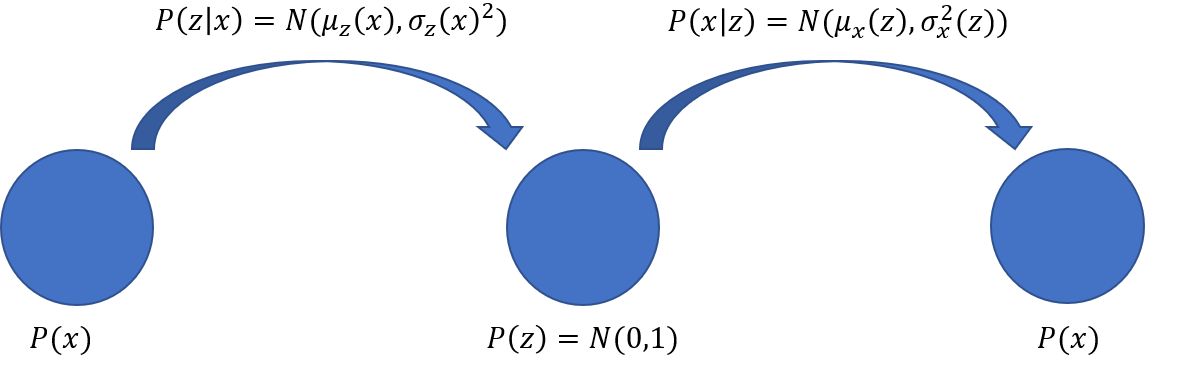
We want prior of hidden variable $P(z)$ to be described by probability density of standard normal: 
$$P(z)=\mathcal{N}(0,1) \text{ - "prior"}$$
There are two mappings of interest, which are also Gaussian: <br>
$$P(z|x)=\mathcal{N}(\mu_z(x),\sigma_z^2(x)) \text{ - "encoder"}$$
$$P(x|z)=\mathcal{N}(\mu_x(z),\sigma_x^2(z)) \text{ - "decoder"}$$

Marginal probabilities of hidden and input variables are linked by law of total probability:
$$P(z) = \int P(z|x) P(x) dx$$

# Analytically tractable set of parameters
$$P(z) = \mathcal{N}(0,1) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}z^2} $$
$$ x = e^{\hat{x}}, \hat{x} \sim \mathcal{N}(0,\sigma_{\hat{x}}^2 = \frac{1}{2})$$
$$ z = \log x + \epsilon, \epsilon \sim \mathcal{N}(0, \sigma_{\epsilon}^2 = \frac{1}{2})$$
Note that inverse transform is not gaussian:
$$ x = e^z \cdot e^{-\epsilon}$$
$$ E(x|z) = e^{1/4} e^z $$
$$ Var(x|z) = (e-e^{1/2})e^z $$

### Generation of the data

In [2]:
Npoints = 100000
sigma_x = np.sqrt(1/2)
sigma_z = np.sqrt(1/2)

# torch works with float32
x = np.exp(sigma_x * np.random.randn(Npoints))
z = np.log(x) + sigma_z * np.random.randn(Npoints)

x_torch = torch.as_tensor(x.astype('float32')).reshape((-1,1))

In [436]:
Npoints = 100000
k = 5; # number of modes
n = int(Npoints/k) * np.ones(k).astype('int')
n[-1] += Npoints - np.sum(n)
x = []
for j in range(k):
    array = 0.1*np.random.randn(n[j],1)-(0.5+j-k/2)
    print(array.shape)
    x.append(array)

x = np.vstack(x).ravel()
print(x.shape)
x_torch = torch.as_tensor(x.astype('float32')).reshape((-1,1))
x_torch.shape

(20000, 1)
(20000, 1)
(20000, 1)
(20000, 1)
(20000, 1)
(100000,)


torch.Size([100000, 1])

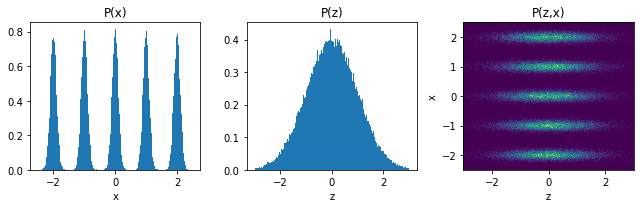

In [439]:
def plot_histograms(x, z, nbins=50, xy_range = 3, z_range=3):
    fig = plt.figure(figsize=(9,3))
    plt.subplot(131)
    plt.hist(x, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('x')
    plt.title('P(x)')
    plt.subplot(132)
    plt.hist(z, bins=nbins, density = True, range=(-z_range,z_range));
    plt.xlabel('z')
    plt.title('P(z)')
    plt.subplot(133)
    counts, xbins, ybins = np.histogram2d(z, x, bins=(nbins, nbins), density=True, range=((-z_range,z_range),(-xy_range,xy_range)))
    counts = counts.T
    plt.pcolormesh(xbins, ybins, counts)
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title('P(z,x)')
    plt.tight_layout()
plot_histograms(x,z,200,xy_range=2.5)

# Variational inference (VI)
Define parametric approximations for encoder and decoder: <br>
<center> $P(z|x) \to q_{\phi}(z|x)$ and $P(x|z) \to q_{\theta}(x|z)$ </center>
Specify explicit form of encoder and decoder with Neural networks:
$$q_{\phi}(z|x) =\mathcal{N}(g(x),h(x))$$
$$q_{\theta}(x|z)=\mathcal{N}(f(z),c(z))$$
where $h(x)$ and $c(z)$ - variances.
Then Loss function:
$$L_{VAE}(x_i) = \frac{1}{2} \mathbb{E}_{z \sim \mathcal{N}(g(x_i),h(x_i))} \left[ \log c(z) + \frac{(x_i - f(z))^2}{c(z)} \right] + D_{KL}(\mathcal{N}(g(x_i),h(x_i)), \mathcal{N}(0,1))$$
Last approximation - change expectation with 1 Monte-Carlo sample (https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73):
$$L_{VAE}(x_i) = \frac{1}{2} \log c(z) + \frac{(x_i - f(z_i))^2}{2c(z)} + \left[ - \frac{1}{2} \log h(x_i) + \frac{h(x_i) + (g(x_i))^2}{2} - \frac{1}{2} \right]$$
$$z_i = g(x_i) + \xi \sqrt{h(x_i)}, \xi \sim \mathcal{N}(0,1)$$

In [440]:
class Net(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        
        encoder_blocks = []
        encoder_blocks.extend([nn.Linear(1,width), nn.ReLU(), nn.BatchNorm1d(width)])
        for j in range(depth-2):
            encoder_blocks.extend([nn.Linear(width,width), nn.ReLU(), nn.BatchNorm1d(width)])
        encoder_blocks.append(nn.Linear(width,2))
        
        self.encoder = nn.Sequential(*encoder_blocks)
        
        decoder_blocks = []
        decoder_blocks.extend([nn.Linear(1,width), nn.ReLU(), nn.BatchNorm1d(width)])
        for j in range(depth-2):
            decoder_blocks.extend([nn.Linear(width,width), nn.ReLU(), nn.BatchNorm1d(width)])
        decoder_blocks.append(nn.Linear(width,2))
        
        self.decoder = nn.Sequential(*decoder_blocks)
    
    def forward(self, x):
        z = self.encoder(x)
        
        mean_z = z[:,0:1]
        var_z = nn.functional.softplus(z[:,1:2])
        
        z_sample = mean_z + torch.sqrt(var_z) * torch.randn(var_z.shape)
        
        y = self.decoder(z_sample)
        mean_x = y[:,0:1]
        var_x = nn.functional.softplus(y[:,1:2])
        return mean_x, var_x, mean_z, var_z
    
    def generate_data(self, x):
        with torch.no_grad():
            self.eval()
            N = x.shape[0]
            # generate outputs
            z_gen = torch.randn(N,1)
            x_gen = self.decoder(z_gen)[:,0:1]
            
            # generate aggregated posterior and reconstruction
            z = self.encoder(x)
            mean_z = z[:,0:1]
            var_z = nn.functional.softplus(z[:,1:2])
            z_recon = mean_z + torch.sqrt(var_z) * torch.randn(var_z.shape)
            x_recon = self.decoder(z_recon)[:,0:1]
            
            return z_recon.numpy().squeeze(), x_recon.numpy().squeeze(), z_gen.numpy().squeeze(), x_gen.numpy().squeeze()
    def channels(self, xx, zz):
        with torch.no_grad():
            z = self.encoder(xx)
            mean_z = z[:,0:1]
            var_z = nn.functional.softplus(z[:,1:2])

            y = self.decoder(zz)
            mean_x = y[:,0:1]
            var_x = nn.functional.softplus(y[:,1:2])
            return mean_x, var_x, mean_z, var_z

In [441]:
def minibatch(x, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yield xx

In [442]:
# can be used for scalars, as well as for vectors
def KL(mu1,var1,mu2,var2):
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    out = 0.5*(torch.log(var2/var1) + (var1+torch.square(mu1-mu2))/var2-1)
    return out

In [443]:
# error per element
# https://ieeexplore.ieee.org/document/6289001, 
# formula 18
# loss compared to N(0,1)
def WGMM_loss(mean_z, var_z):
    # number of elements in a mixture
    # is the batch size
    n = mean_z.shape[0]
    
    term0 = KL(mean_z, var_z, 0, 1)
    
    term1 = torch.zeros(n,1)
    for i in range(n):
        term1[i] = torch.log(torch.exp(-KL(mean_z[i],var_z[i],mean_z,var_z)).mean())
    return term0 + term1
mz = torch.randn(3000,1)
vz = 0.000001*torch.ones(3000,1)
print(WGMM_loss(mz,vz).mean())
print(KL(mz,vz,0,1).mean())

tensor(-0.0838)
tensor(6.8965)


In [444]:
def criterion(true_x, mean_x, var_x, mean_z, var_z, regularize):
    error_gauss = 0.5 * (torch.log(var_x) + torch.square(true_x-mean_x) / var_x)
    if regularize == 'VAE':
        error_reg = 0.5*((var_z + torch.square(mean_z)) - torch.log(var_z) - 1)
    elif regularize == 'WGMM':
        error_reg = WGMM_loss(mean_z, var_z)    
    elif regularize == 'AE':
        error_reg = error_gauss * 0
        
    error = error_gauss + error_reg
    
    n = error.shape[0]
    with torch.no_grad():
        error_sum = error.mean().item() * n
        
    return error.mean(), error_sum, n

In [445]:
from time import time
def train(net, x, lr=0.001, num_epochs=100, batch_size=64, regularize = 'VAE'):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    
    net.loss = {'VAE_loss': []}
    net.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_n = 0
        t = time()
        for xx in minibatch(x, batch_size):
            optimizer.zero_grad()
            mean_x, var_x, mean_z, var_z = net.forward(xx)
            loss, error, n = criterion(xx, mean_x, var_x, mean_z, var_z, regularize)
            loss.backward()
            optimizer.step()
            
            epoch_loss += error
            epoch_n += n
        net.loss['VAE_loss'].append(epoch_loss / epoch_n)
        scheduler.step()
        t = time() - t
        
        if epoch%10 == 0:
            print(f"epoch = {epoch+1}, numpoints = {epoch_n}, VAE_loss = {epoch_loss / epoch_n}, epoch time = {t}")

In [451]:
net = Net(100,10)

In [452]:
train(net, x_torch, batch_size = 2048, num_epochs=101, regularize='VAE')

epoch = 1, numpoints = 100000, VAE_loss = 1.1151825857162476, epoch time = 1.5117969512939453
epoch = 11, numpoints = 100000, VAE_loss = 0.6172078421211242, epoch time = 1.4963037967681885
epoch = 21, numpoints = 100000, VAE_loss = 0.23285756237030028, epoch time = 1.494410753250122
epoch = 31, numpoints = 100000, VAE_loss = 0.18006094594478608, epoch time = 1.4891386032104492
epoch = 41, numpoints = 100000, VAE_loss = 0.17806184541702272, epoch time = 1.493251085281372
epoch = 51, numpoints = 100000, VAE_loss = 0.14129638959884644, epoch time = 1.4897396564483643
epoch = 61, numpoints = 100000, VAE_loss = 0.09895339589476586, epoch time = 1.4845693111419678
epoch = 71, numpoints = 100000, VAE_loss = 0.08318748025894165, epoch time = 1.4992735385894775
epoch = 81, numpoints = 100000, VAE_loss = 0.06586205217838287, epoch time = 1.4845762252807617
epoch = 91, numpoints = 100000, VAE_loss = 0.06846884277224541, epoch time = 1.486828088760376
epoch = 101, numpoints = 100000, VAE_loss = 0.

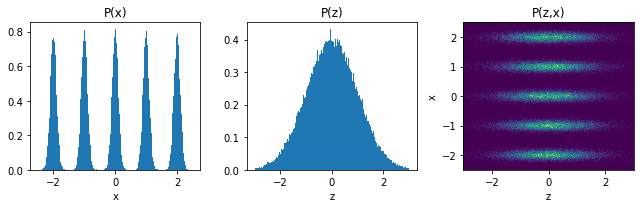

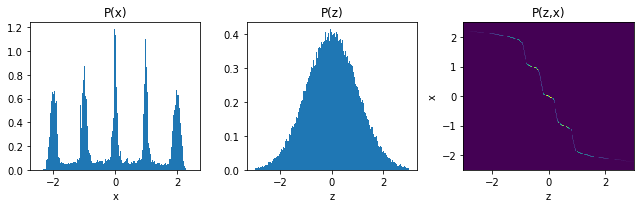

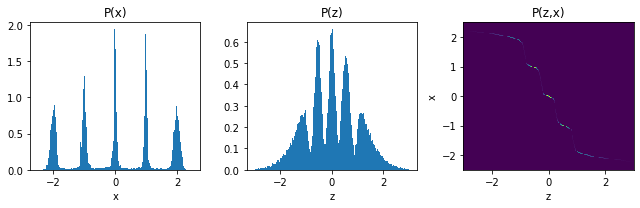

In [454]:
z_recon, x_recon, z_gen, x_gen = net.generate_data(x_torch)
plot_histograms(x,z,200,xy_range=2.5)
plot_histograms(x_gen, z_gen, 200, xy_range=2.5)
plot_histograms(x_recon, z_recon, 200, xy_range=2.5)

In [459]:
train(net, x_torch, batch_size = 2048, num_epochs=61, regularize='WGMM')

epoch = 1, numpoints = 100000, VAE_loss = -2.5251362567138673, epoch time = 41.081419229507446
epoch = 11, numpoints = 100000, VAE_loss = -3.1972250058746337, epoch time = 41.44663119316101
epoch = 21, numpoints = 100000, VAE_loss = -2.5796590102386476, epoch time = 41.37935185432434
epoch = 31, numpoints = 100000, VAE_loss = -3.3290819664001465, epoch time = 41.46694588661194
epoch = 41, numpoints = 100000, VAE_loss = -3.6730641468048097, epoch time = 41.87885618209839
epoch = 51, numpoints = 100000, VAE_loss = -3.909708061294556, epoch time = 41.33359122276306
epoch = 61, numpoints = 100000, VAE_loss = -3.8012840493011475, epoch time = 41.53148818016052


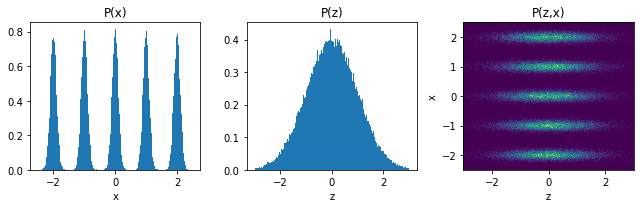

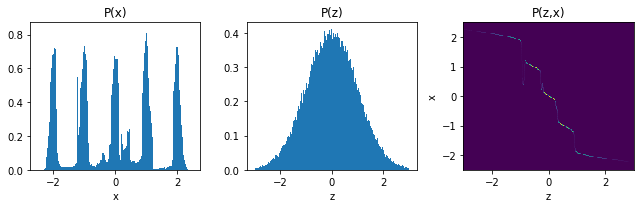

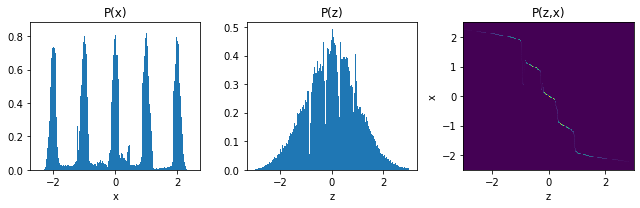

In [461]:
z_recon, x_recon, z_gen, x_gen = net.generate_data(x_torch)
plot_histograms(x,z,200,xy_range=2.5)
plot_histograms(x_gen, z_gen, 200, xy_range=2.5)
plot_histograms(x_recon, z_recon, 200, xy_range=2.5)